## This Notebook gives an example on how plot estimated CAG expansion distribution among cell types (Figure 4 and Supplementary Figure 11 and 12 in the manuscript)

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import  spearmanr, pearsonr
from adjustText import adjust_text

In [2]:
adata=sc.read_h5ad('../adata_0803_0908_f_AGG_orig.h5ad')

In [3]:
###Calibratee

for pt in adata.obs['patient'].unique():
    df = adata[adata.obs['patient'] == pt]
    print(f'{pt} CAG level: {np.mean(df.obs["CAG"])}')

H1 CAG level: 0.13225250967245245
H2 CAG level: 0.12327107536580244
H4 CAG level: 0.13750073235061722
C1 CAG level: 0.10053501356134432
C3 CAG level: 0.09537956556951466
H3 CAG level: 0.1559221329011508
H5 CAG level: 0.16299725726571754
C4 CAG level: 0.10318438726314719
C5 CAG level: 0.10334483236906213


In [4]:
#Estimated Mean CAG

adata.obs['CAG_length'] = [
    (cag_level - 0.0464) / 0.0024 if batch == 'Aug' else (cag_level - 0.0462) / 0.003
    for cag_level, batch in zip(adata.obs['CAG'], adata.obs['batch'])
]

In [5]:
wt_allele = {
    "C1": 30, "C3": 19, "C4": 19, "C5": 17,
    "H1": 22, "H2": 20, "H3": 19, "H4": 20, "H5": 19
}

In [6]:
#Estimated Mutant CAG

for pt in adata.obs['patient'].unique():
    if pt in wt_allele:
        mask = adata.obs['patient'] == pt
        adata.obs.loc[mask, "CAG_mut"] = (
            adata.obs.loc[mask, "CAG_length"] * 2 - wt_allele[pt]
        )

In [7]:
for pt in adata.obs['patient'].unique():
    df = adata[adata.obs['patient'] == pt]
    print(f'{pt} CAG level: {np.mean(df.obs["CAG_mut"])}')

H1 CAG level: 49.54375806037704
H2 CAG level: 44.05922947150206
H4 CAG level: 55.91727695884768
C1 CAG level: 15.112511301120255
C3 CAG level: 21.81630464126221
H3 CAG level: 54.14808860076721
H5 CAG level: 58.86483817714501
C4 CAG level: 18.989591508764796
C5 CAG level: 21.096554912708083


In [8]:
##################################################
#### SUPPLEMENTARY FIGURE 11A: Pupulation size with HTT all, HTT>5, HTT>10
##################################################

In [9]:
HTT_5 = adata[adata.obs['nHTT'] > 5]
HTT_10 = adata[adata.obs['nHTT'] > 10]

In [10]:
total_cells = adata.n_obs

df_httall = (
    adata.obs['cluster_general']
    .value_counts()
    .rename('n_cells')
    .to_frame()
)

df_httall['percent'] = df_httall['n_cells'] / total_cells * 100
df_httall.attrs['total_cells'] = total_cells
df_httall.to_csv('processed_data/n_cells_HTTall.csv')
df_httall

,n_cells,percent
cluster_general,,
Oligodendrocytes,58323,31.403557
Excitatory Neurons,36855,19.844283
Astrocytes,27200,14.645624
Inhibitory Neurons,18786,10.115173
Endothelial,13244,7.131127
Microglia,12196,6.566840
VLMC,9717,5.232042
OPC,7239,3.897782


In [11]:
total_cells = HTT_5.n_obs

df_htt5 = (
    HTT_5.obs['cluster_general']
    .value_counts()
    .rename('n_cells')
    .to_frame()
)

df_htt5['percent'] = df_htt5['n_cells'] / total_cells * 100
df_htt5.attrs['total_cells'] = total_cells
df_htt5.to_csv('processed_data/n_cells_HTT5.csv')
df_htt5

,n_cells,percent
cluster_general,,
Excitatory Neurons,26216,52.708191
Inhibitory Neurons,9078,18.251639
Astrocytes,5431,10.919217
Oligodendrocytes,5033,10.119024
OPC,1657,3.331457
Microglia,933,1.875829
Endothelial,815,1.638586
VLMC,543,1.091721


In [12]:
total_cells = HTT_10.n_obs

df_htt10 = (
    HTT_10.obs['cluster_general']
    .value_counts()
    .rename('n_cells')
    .to_frame()
)

df_htt10['percent'] = df_htt10['n_cells'] / total_cells * 100
df_htt10.attrs['total_cells'] = total_cells
df_htt10.to_csv('processed_data/n_cells_HTT10.csv')
df_htt10

,n_cells,percent
cluster_general,,
Excitatory Neurons,19371,71.117556
Inhibitory Neurons,4821,17.699537
Astrocytes,1179,4.328512
Oligodendrocytes,1108,4.067846
OPC,508,1.865041
Microglia,135,0.495631
Endothelial,64,0.234966
VLMC,51,0.187238


In [13]:
##################################################
#### FIGURE 4D: Percent of cells with CAG<60
##################################################

In [14]:
data_df = HTT_5.obs[[ 'cluster_names','cluster_general','patient','CAG_mut']].copy()

data_df['Condition'] = '<60'
data_df.loc[(data_df['CAG_mut']>=60), 'Condition'] = '60-140'
data_df.loc[(data_df['CAG_mut']>=140), 'Condition'] = '140-220'
data_df.loc[(data_df['CAG_mut']>=220), 'Condition'] = '220-300'
data_df.loc[(data_df['CAG_mut']>=300), 'Condition'] = '300-380'
data_df.loc[(data_df['CAG_mut']>=380), 'Condition'] =  '>380'

In [15]:
# Count cells per cluster/condition/patient Major CL
condition_counts = (
    data_df
    .groupby(['patient', 'cluster_general', 'Condition'])
    .size()
    .unstack(fill_value=0)
)

total_counts = condition_counts.sum(axis=1)

percentages_patient = (condition_counts.T / total_counts).T * 100
percentages_patient = percentages_patient.reset_index() 
percentages_patient['HD'] = percentages_patient['patient'].str.startswith('H')
percentages_patient.to_csv('processed_data/CAG_bins_major_cl.csv')

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/2414351574.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_df


In [16]:
# Count cells per cluster/condition/patient
condition_counts = (
    data_df
    .groupby(['patient', 'cluster_names', 'Condition'])
    .size()
    .unstack(fill_value=0)
)

total_counts = condition_counts.sum(axis=1)

percentages_patient = (condition_counts.T / total_counts).T * 100
percentages_patient = percentages_patient.reset_index() 
percentages_patient['HD'] = percentages_patient['patient'].str.startswith('H')
percentages_patient.to_csv('processed_data/CAG_bins.csv')

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/3794852099.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_df


In [17]:
##################################################
#### SUPPLEMENTARY FIGURE 11B: Distribution of mutant CAG per cell by donor
##################################################

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seabor

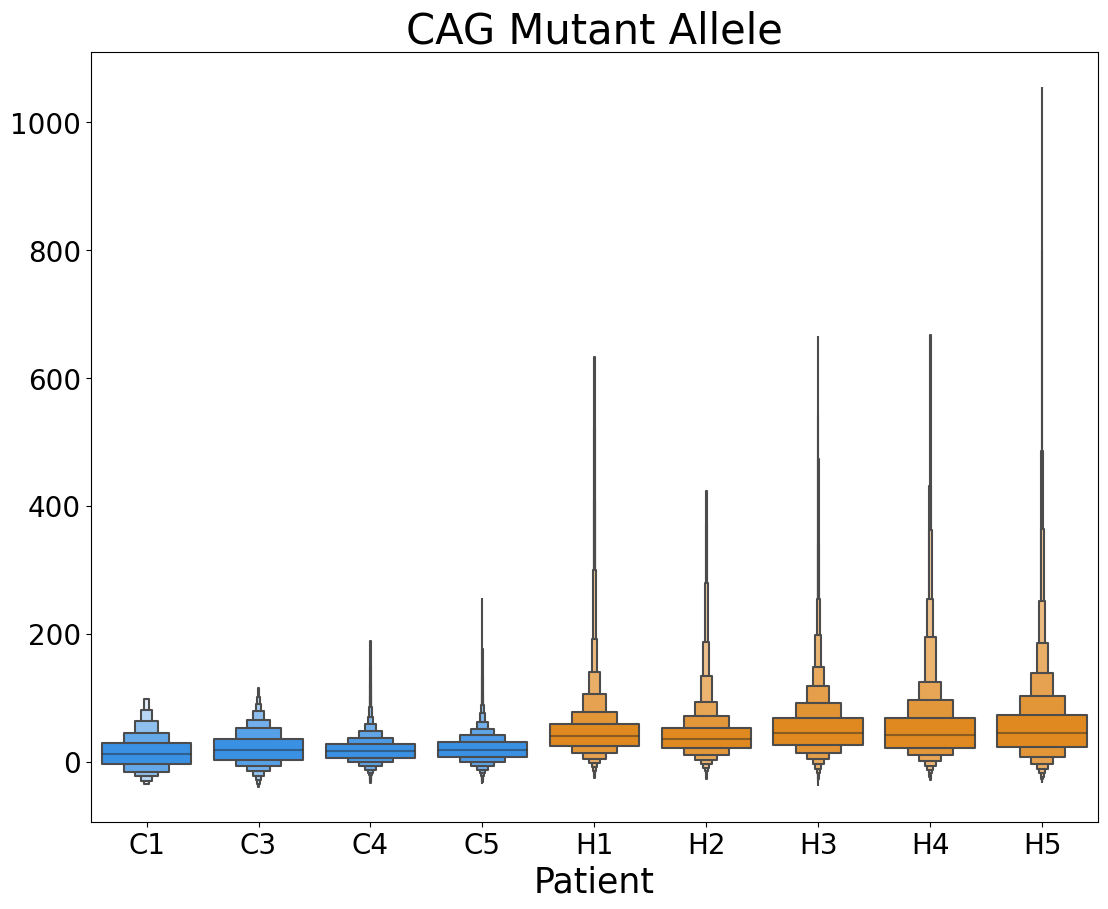

In [18]:
cmap = ['#1E90FF','#1E90FF','#1E90FF','#1E90FF','#FF8C00','#FF8C00','#FF8C00','#FF8C00','#FF8C00']

plt.figure(figsize=(13, 10))

sns.boxenplot(x='patient', y='CAG_mut', data=HTT_5.obs,palette=cmap, width=0.8,linewidth=1.5,showfliers=False)

plt.title('CAG Mutant Allele', fontsize=30)
plt.xticks (fontsize=20) 
plt.yticks(fontsize=20) 
plt.xlabel('Patient', fontsize=25)
plt.ylabel('',fontsize=30)
plt.grid(False)
plt.show()

In [19]:
##################################################
#### SUPPLEMENTARY FIGURE 11C
##################################################

In [20]:
adata.obs['Expansion'] = adata.obs['CAG_mut'] >= 150
adata.obs['Expansion'] = adata.obs['Expansion'].apply(lambda x: True if x else False)

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/1031029022.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (patient, cluster) in data_df.groupby(['patient', 'cluster_general']):
/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/1031029022.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depre

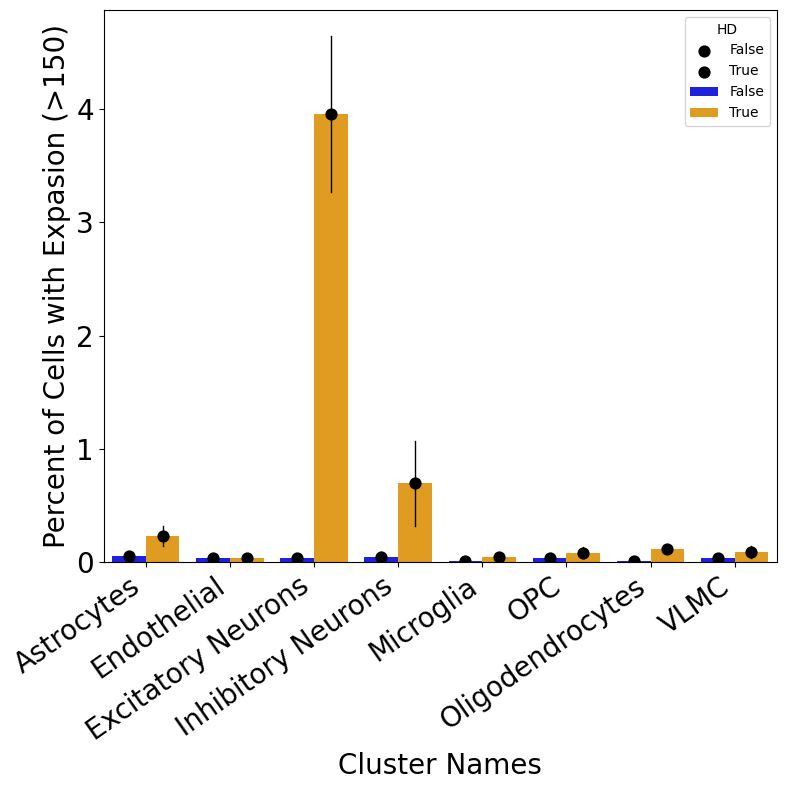

In [21]:
hd_palette = {'True': '#FFA500', 'False': '#0000FF'}
se_palette = {'True': 'black', 'False': 'black'}

data_df = adata.obs[['Expansion','patient', 'cluster_general','cluster_names', 'Agg', 'HD']].copy()
data_df['Expansion'] = data_df['Expansion'].fillna(False).astype('bool')

exp_percentages_all = []

for (patient, cluster) in data_df.groupby(['patient', 'cluster_general']):
    total_cells = len(cluster)
    percent_with_exp = np.sum(cluster['Expansion']) / total_cells * 100
    
    exp_percentages_all.append({
        'patient': patient,
        'cluster_general': cluster['cluster_general'].iloc[0],
        'percent_with_exp': percent_with_exp,
        'HD': str(cluster['HD'].iloc[0])  # Convert HD status to string
    })

exp_all_percent_df = pd.DataFrame(exp_percentages_all)

exp_stats_all = exp_all_percent_df.groupby(['cluster_general', 'HD']).agg(
    mean_with_exp=('percent_with_exp', 'mean')
).reset_index()

plt.figure(figsize=(8, 8))

ax = sns.barplot(
    x='cluster_general', y='mean_with_exp', hue='HD',
    data=exp_stats_all, palette=hd_palette, ci=None, dodge=True
)

sns.pointplot(
    x='cluster_general', y='percent_with_exp',
    data=exp_all_percent_df, palette=se_palette, hue='HD', dodge=0.4, join=False, errorbar=('se', 1),  errwidth=1
)

plt.xlabel('Cluster Names', fontsize=20)
plt.ylabel('Percent of Cells with Expasion (>150)', fontsize=20)
plt.xticks(rotation=35, fontsize=20, ha='right')
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

In [22]:
##################################################
#### SUPPLEMENTARY FIGURE 11D
##################################################

In [23]:
Neurons5 = HTT_5[HTT_5.obs['cluster_general'].isin(['Excitatory Neurons', 'Inhibitory Neurons'])].copy()

In [24]:
cluster_order =['L2.IT', 'L3.IT', 'L5.IT', 'L4.IT', 'L5.ET', 'L5.6.NP', 'L6.IT', 'L6.CT', 'L6.Car3', 'L6b','Chandelier', 'LAMP5', 'PVALB', 'SNCG', 'SST', 'VIP' ]

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/1097981203.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (patient, cluster) in data_df.groupby(['patient', 'cluster_names']):
/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/1097981203.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = percent_df_CAG.groupby(['cluster_names', 'HD'])
/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/1097981203.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/Users/Olatz/anaconda3/envs/napa

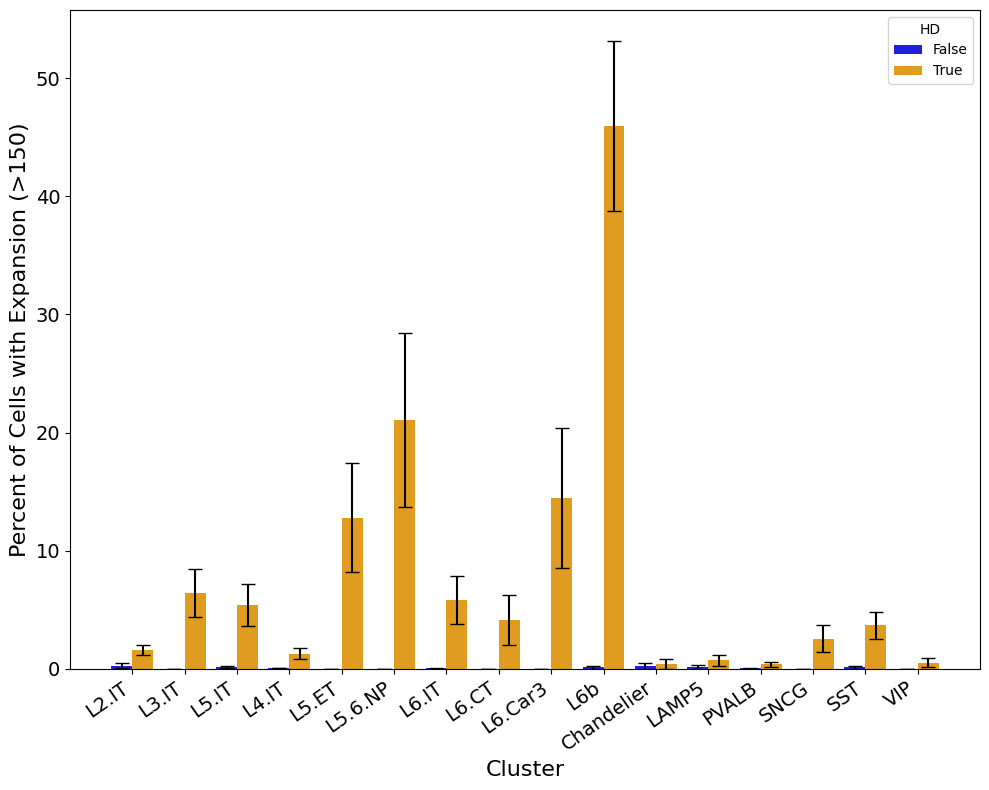

In [25]:
data_df = Neurons5.obs[['Expansion','patient', 'cluster_general','cluster_names', 'HD']].copy()
data_df['Expansion'] = data_df['Expansion'].fillna(False).astype(bool)
data_df['HD'] = data_df['HD'].astype(str)

percentages = []

for (patient, cluster) in data_df.groupby(['patient', 'cluster_names']):
    total_cells = len(cluster)
    percent_with_exp = np.sum(cluster['Expansion']) / total_cells * 100
    percentages.append({
        'patient': patient,
        'cluster_names': cluster['cluster_names'].iloc[0],
        'percent_with_exp': percent_with_exp,
        'HD': cluster['HD'].iloc[0]
    })

percent_df_CAG = pd.DataFrame(percentages)
percent_df_CAG['cluster_names'] = pd.Categorical(percent_df_CAG['cluster_names'], categories=cluster_order, ordered=True)

grouped = percent_df_CAG.groupby(['cluster_names', 'HD'])
summary_df = grouped['percent_with_exp'].agg(['mean', 'sem']).reset_index()
summary_df.rename(columns={'mean': 'mean_with_exp', 'sem': 'se_with_exp'}, inplace=True)

plt.figure(figsize=(10, 8))
order = cluster_order

ax = sns.barplot(
    data=summary_df,
    x='cluster_names', y='mean_with_exp', hue='HD',
    palette=hd_palette, order=order, dodge=True, ci=None
)

hue_offset = {'False': -0.2, 'True': 0.2} 
for i, cluster in enumerate(order):
    for hd in ['False', 'True']:
        subset = summary_df[(summary_df['cluster_names'] == cluster) & (summary_df['HD'] == hd)]
        if not subset.empty:
            y = subset['mean_with_exp'].values[0]
            yerr = subset['se_with_exp'].values[0]
            x = i + hue_offset[hd]
            ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black', capsize=5, linewidth=1.5)

plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Percent of Cells with Expansion (>150)', fontsize=16)
plt.xticks(rotation=35, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='HD')
plt.tight_layout()
plt.show()


In [26]:
summary_df_hd=summary_df[summary_df['HD']=='True'].copy()

In [27]:
##################################################
#### FIGURE 4E: CAG bins in HD Neuronal clusters
##################################################

In [28]:
Neurons5_HD = Neurons5[Neurons5.obs['HD']==True].copy()
Neurons5_CTL= Neurons5[Neurons5.obs['HD']==False].copy()

In [29]:
cluster_order = [ "L2.IT", "L3.IT","L4.IT",'L5.IT', 'L5.ET', "L5.6.NP",'L6.IT', 'L6.Car3', "L6.CT",'L6b',"Chandelier","LAMP5","PVALB", "SNCG",'VIP', "SST" ]

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/2746359375.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condition_counts = data_df.groupby(['cluster_names', 'Condition']).size().unstack(fill_value=0)


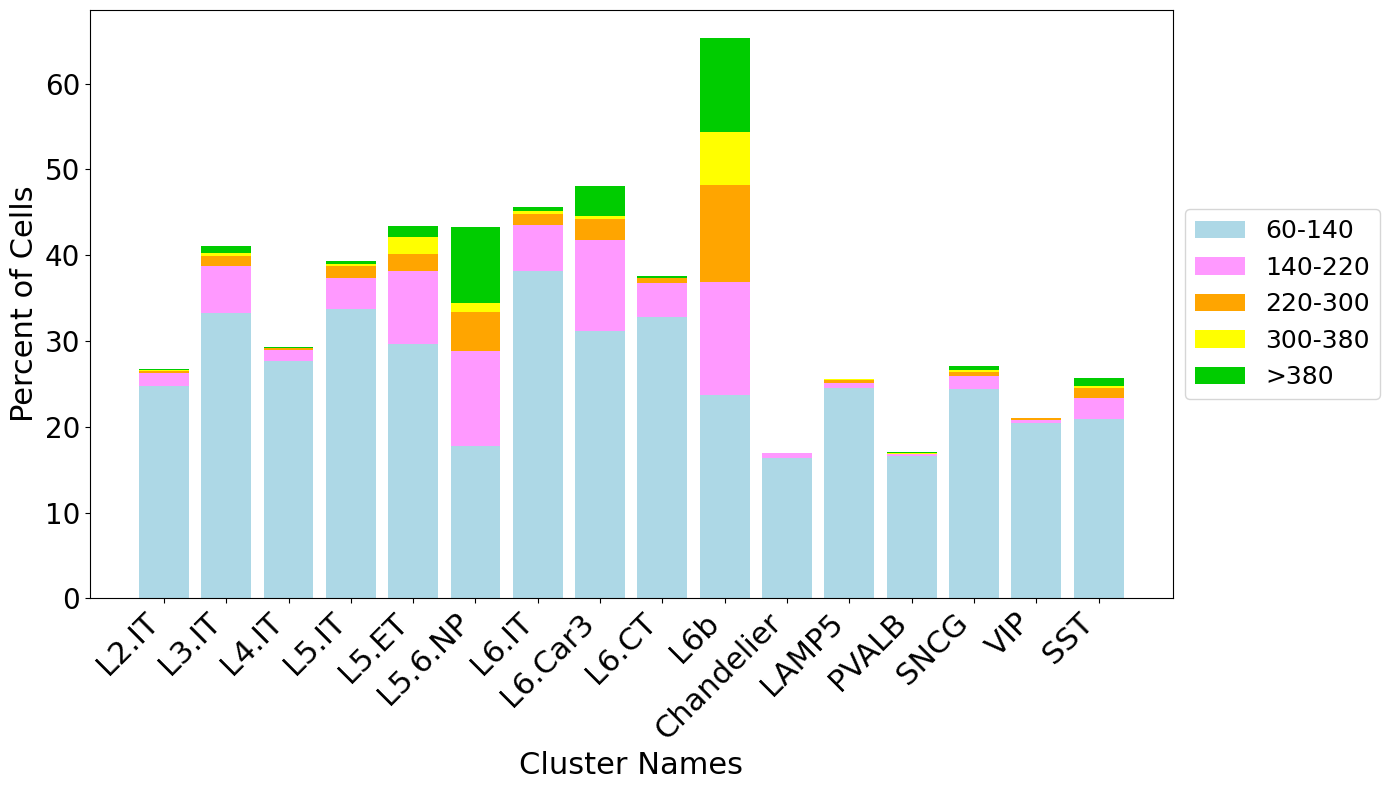

In [30]:
data_df = Neurons5_HD.obs[[ 'cluster_names','patient','CAG_mut']].copy()

data_df['Condition'] = '<60'  # Default
data_df.loc[(data_df['CAG_mut']>=60), 'Condition'] = '60-140'
data_df.loc[(data_df['CAG_mut']>=140), 'Condition'] = '140-220'
data_df.loc[(data_df['CAG_mut']>=220), 'Condition'] = '220-300'
data_df.loc[(data_df['CAG_mut']>=300), 'Condition'] = '300-380'
data_df.loc[(data_df['CAG_mut']>=380), 'Condition'] =  '>380'

condition_counts = data_df.groupby(['cluster_names', 'Condition']).size().unstack(fill_value=0)
total_counts = condition_counts.sum(axis=1)
percentages = (condition_counts.T / total_counts).T * 100

percentages = percentages.loc[cluster_order]

clusters = percentages.index
conditions = ['60-140', '140-220', '220-300', '300-380', '>380']
bar_width = 0.8
index = np.arange(len(clusters))

colors = {
    '60-140': 'lightblue',
    '140-220': '#ff99ff',
    '220-300': 'orange',
    '300-380':'yellow',
      '>380':'#00cc00'
}

plt.figure(figsize=(14, 8))

bottoms = np.zeros(len(clusters))
for condition in conditions:
    if condition in percentages.columns:
        plt.bar(index, percentages[condition], bar_width,
                bottom=bottoms, label=condition, color=colors[condition])
        bottoms += percentages[condition]
        
plt.title('', fontsize=25)
plt.xlabel('Cluster Names', fontsize=22)
plt.ylabel('Percent of Cells', fontsize=22)
plt.xticks(index, clusters, fontsize=22, rotation=45, ha='right')
plt.yticks(fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.tight_layout()
plt.show()

In [31]:
##################################################
#### FIGURE 4D: CAG >380 in HD Neuronal clusters
##################################################

In [32]:
condition_counts = (
    data_df
    .groupby(['patient', 'cluster_names', 'Condition'])
    .size()
    .unstack(fill_value=0)
)

total_counts = condition_counts.sum(axis=1)
percentages_patient = (condition_counts.T / total_counts).T * 100

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/3848457342.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_df


/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/1178363874.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentages_mean = percentages_patient.groupby('cluster_names').mean()
/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/1178363874.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentages_sem = percentages_patient.groupby('cluster_names').sem()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


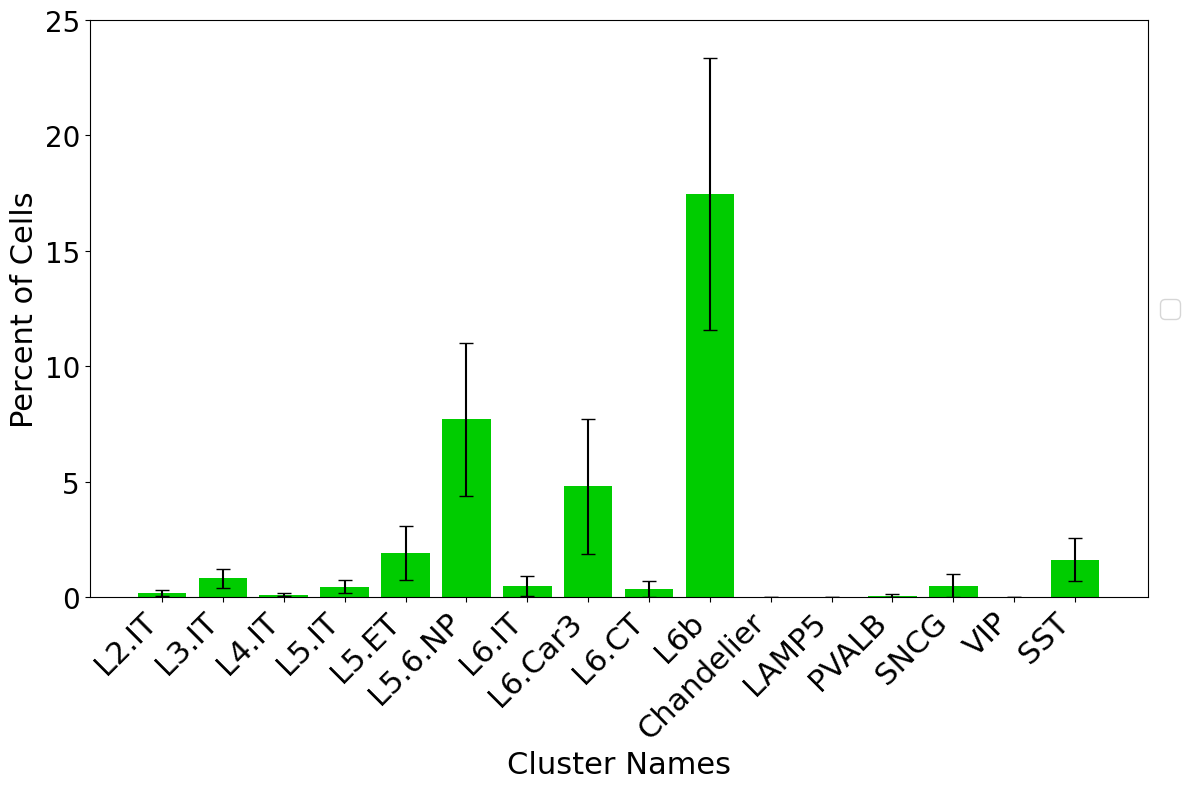

In [33]:
percentages_mean = percentages_patient.groupby('cluster_names').mean()
percentages_sem = percentages_patient.groupby('cluster_names').sem()

percentages_mean = percentages_mean.reindex(cluster_order)
percentages_sem  = percentages_sem.reindex(cluster_order)

clusters = percentages_mean.index
condition = '>380'

means = percentages_mean[condition]
sems  = percentages_sem[condition]

plt.figure(figsize=(12, 8))
plt.bar(clusters, means, yerr=sems, 
        color=colors[condition], capsize=5)

plt.title('', fontsize=25)
plt.xlabel('Cluster Names', fontsize=22)
plt.ylabel('Percent of Cells', fontsize=22)
plt.xticks(rotation=45, ha='right', fontsize=22)
plt.yticks(fontsize=20)
plt.ylim(0, 25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)

plt.tight_layout()
plt.show()

In [34]:
##################################################
#### SUPPLEMENTARY FIGURE 11E: CAG length bins in CTL cortex
##################################################

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/4070167111.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condition_counts = data_df.groupby(['cluster_names', 'Condition']).size().unstack(fill_value=0)


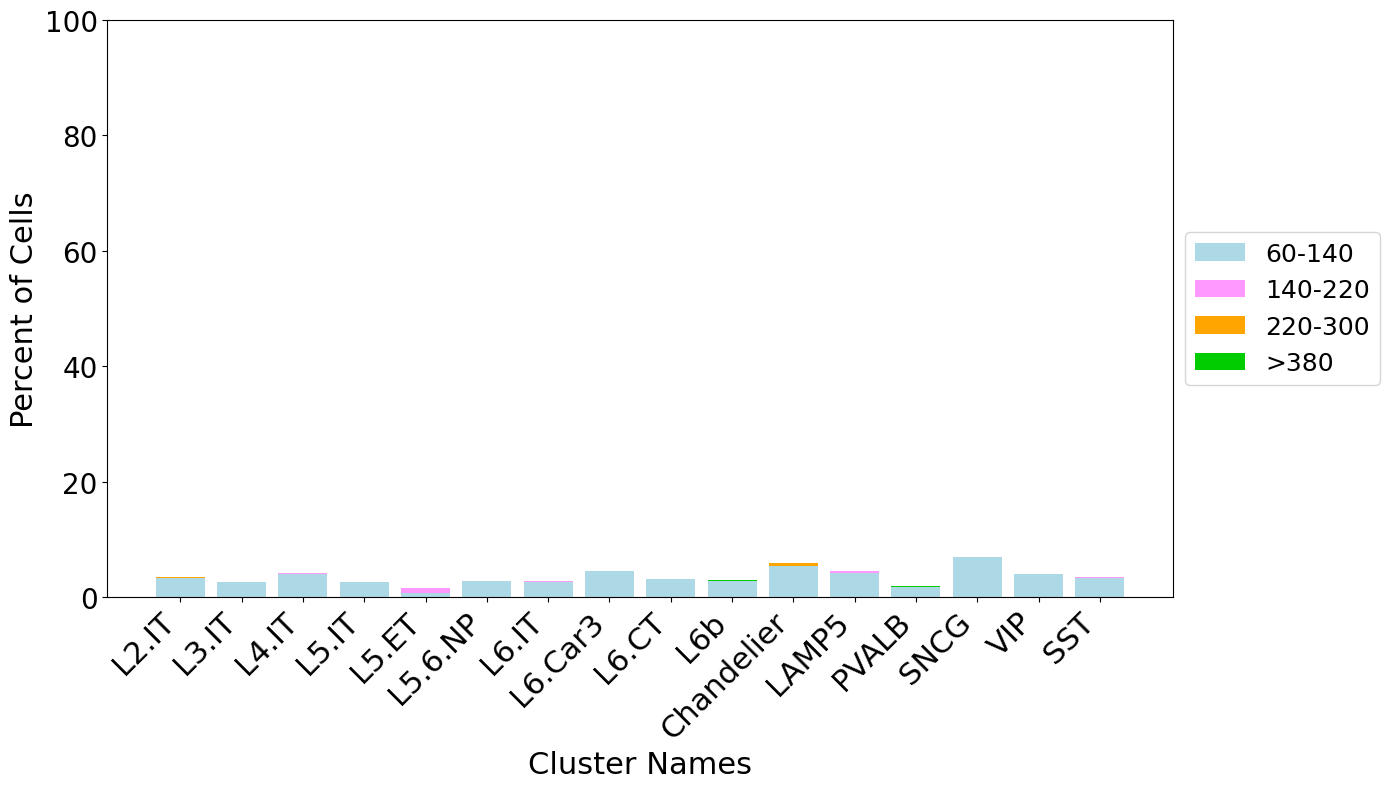

In [35]:
data_df = Neurons5_CTL.obs[[ 'cluster_names','patient','CAG_mut']].copy()

data_df['Condition'] = '<60'  # Default
data_df.loc[(data_df['CAG_mut']>=60), 'Condition'] = '60-140'
data_df.loc[(data_df['CAG_mut']>=140), 'Condition'] = '140-220'
data_df.loc[(data_df['CAG_mut']>=220), 'Condition'] = '220-300'
data_df.loc[(data_df['CAG_mut']>=300), 'Condition'] = '300-380'
data_df.loc[(data_df['CAG_mut']>=380), 'Condition'] =  '>380'

condition_counts = data_df.groupby(['cluster_names', 'Condition']).size().unstack(fill_value=0)
total_counts = condition_counts.sum(axis=1)
percentages_ctl = (condition_counts.T / total_counts).T * 100

percentages_ctl = percentages_ctl.loc[cluster_order]

clusters = percentages_ctl.index
conditions = ['60-140', '140-220', '220-300', '300-380', '>380']
bar_width = 0.8
index = np.arange(len(clusters))

colors = {
    '60-140': 'lightblue',
    '140-220': '#ff99ff',
    '220-300': 'orange',
    '300-380':'yellow',
      '>380':'#00cc00'
}

plt.figure(figsize=(14, 8))

bottoms = np.zeros(len(clusters))
for condition in conditions:
    if condition in percentages_ctl.columns:
        plt.bar(index, percentages_ctl[condition], bar_width,
                bottom=bottoms, label=condition, color=colors[condition])
        bottoms += percentages_ctl[condition]
        
plt.title('', fontsize=25)
plt.xlabel('Cluster Names', fontsize=22)
plt.ylabel('Percent of Cells', fontsize=22)
plt.ylim(0,100)
plt.xticks(index, clusters, fontsize=22, rotation=45, ha='right')
plt.yticks(fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.tight_layout()
plt.show()

In [36]:
##################################################
#### FIGURES 4G-H: CAG expansion vs Excitatory Neuron loss
##################################################

In [37]:
percent_lost_df = {
    'cluster_names': ['L2.IT', 'L3.IT', 'L5.IT', 'L4.IT', 'L5.ET', 'L5.6.NP', 'L6.IT', 'L6.CT', 'L6.Car3', 'L6b'],
    'Percent Lost': [38.965629, 7.597639, 21.390964, 44.542414, 9.159061, 84.112792, 24.816347, 42.304075, 2.011352, 53.409478]
}

percent_lost_df = pd.DataFrame(percent_lost_df)
percent_lost_df.set_index('cluster_names', inplace=True)

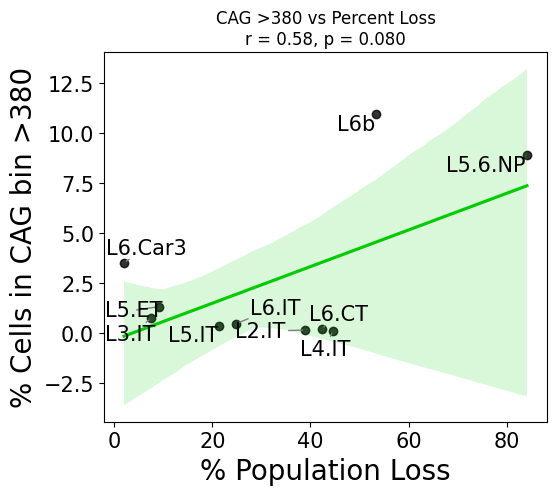

In [38]:
merged = percentages.merge(percent_lost_df, left_index=True, right_index=True)

r, p = pearsonr(merged['>380'], merged['Percent Lost'])

plt.figure(figsize=(5.5, 5))
sns.regplot(data=merged, y='>380', x='Percent Lost', scatter_kws={'color': 'black'}, line_kws={'color': '#00cc00'})

texts = []
for i, row in merged.iterrows():
    texts.append(plt.text( row['Percent Lost'],row['>380'], i, fontsize=15))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'CAG >380 vs Percent Loss\nr = {r:.2f}, p = {p:.3f}')
plt.ylabel(f'% Cells in CAG bin >380', size=20)
plt.xlabel('% Population Loss', size=20)
plt.tight_layout()
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

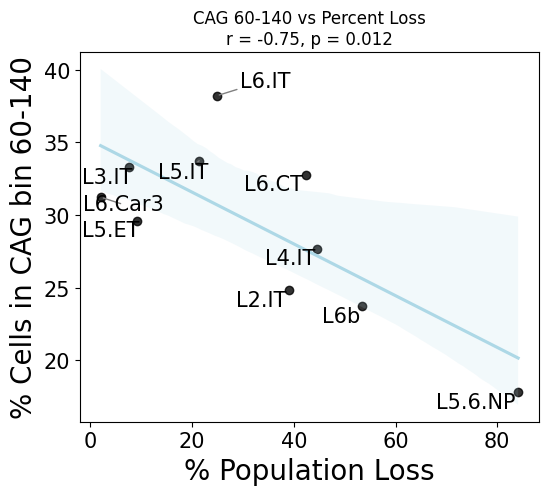

In [39]:
r, p = pearsonr(merged['60-140'], merged['Percent Lost'])

plt.figure(figsize=(5.5, 5))
sns.regplot(data=merged, y='60-140', x='Percent Lost', scatter_kws={'color': 'black'}, line_kws={'color': 'lightblue'})

texts = []
for i, row in merged.iterrows():
    texts.append(plt.text( row['Percent Lost'],row['60-140'], i, fontsize=15))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'CAG 60-140 vs Percent Loss\nr = {r:.2f}, p = {p:.3f}')
plt.ylabel(f'% Cells in CAG bin 60-140', size=20)
plt.xlabel('% Population Loss', size=20)
plt.tight_layout()
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [40]:
##################################################
#### SUPPLEMENTARY FIGURES 11F-G: CAG expansion vs Inhibitory Neuron loss
##################################################

In [41]:
percent_lost_df_inh = {
    'cluster_names': ['Chandelier', 'LAMP5', 'PVALB', 'SNCG', 'SST', 'VIP' ],
    'Percent Lost': [55.550050,7.380457, 14.008406,  -1.760563,   51.870968, 4.372169 ]
}

percent_lost_df_inh = pd.DataFrame(percent_lost_df_inh)
percent_lost_df_inh.set_index('cluster_names', inplace=True)

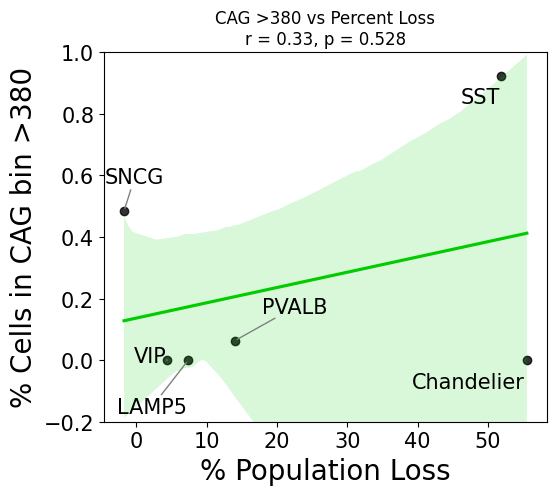

In [42]:
merged = percentages.merge(percent_lost_df_inh, left_index=True, right_index=True)

r, p = pearsonr(merged['>380'], merged['Percent Lost'])

plt.figure(figsize=(5.5, 5))
sns.regplot(data=merged, y='>380', x='Percent Lost', scatter_kws={'color': 'black'}, line_kws={'color': '#00cc00'})

texts = []
for i, row in merged.iterrows():
    texts.append(plt.text( row['Percent Lost'],row['>380'], i, fontsize=15))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'CAG >380 vs Percent Loss\nr = {r:.2f}, p = {p:.3f}')
plt.ylabel(f'% Cells in CAG bin >380', size=20)
plt.xlabel('% Population Loss', size=20)
plt.tight_layout()
plt.ylim(-0.2,1)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

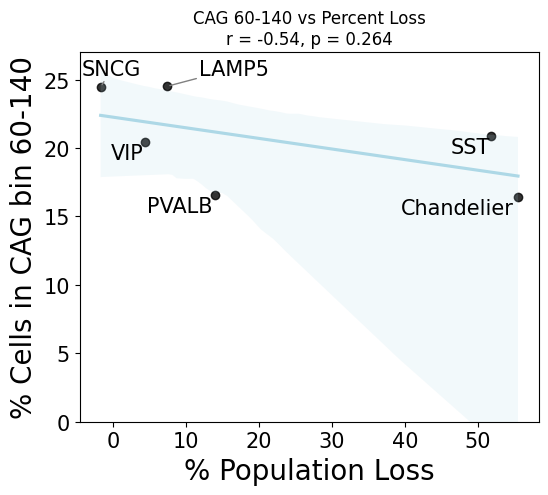

In [43]:
r, p = pearsonr(merged['60-140'], merged['Percent Lost'])

plt.figure(figsize=(5.5, 5))
sns.regplot(data=merged, y='60-140', x='Percent Lost', scatter_kws={'color': 'black'}, line_kws={'color': 'lightblue'})

texts = []
for i, row in merged.iterrows():
    texts.append(plt.text( row['Percent Lost'],row['60-140'], i, fontsize=15))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'CAG 60-140 vs Percent Loss\nr = {r:.2f}, p = {p:.3f}')
plt.ylabel(f'% Cells in CAG bin 60-140', size=20)
plt.xlabel('% Population Loss', size=20)
plt.tight_layout()
plt.ylim(0,27)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### DNA Repair Machinery expression per cluster vs CAG expanison and Neuronal loss

In [44]:
##################################################
#### SUPPLEMENTARY FIGURE 12A: DNA repair machinery expression in Neuronal clusters
##################################################

In [45]:
Nuerons=adata[adata.obs['cluster_general'].isin(['Excitatory Neurons', 'Inhibitory Neurons'])].copy()
Neurons_CTL=Nuerons[Nuerons.obs['HD']==False].copy()

In [46]:
cluster_order_neu = ["LAMP5", "SNCG",'VIP', "SST", "PVALB","Chandelier", "L2.IT", "L3.IT", "L4.IT",'L5.IT', 'L5.ET',"L5.6.NP",'L6.IT','L6.Car3', "L6.CT",'L6b' ]

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(

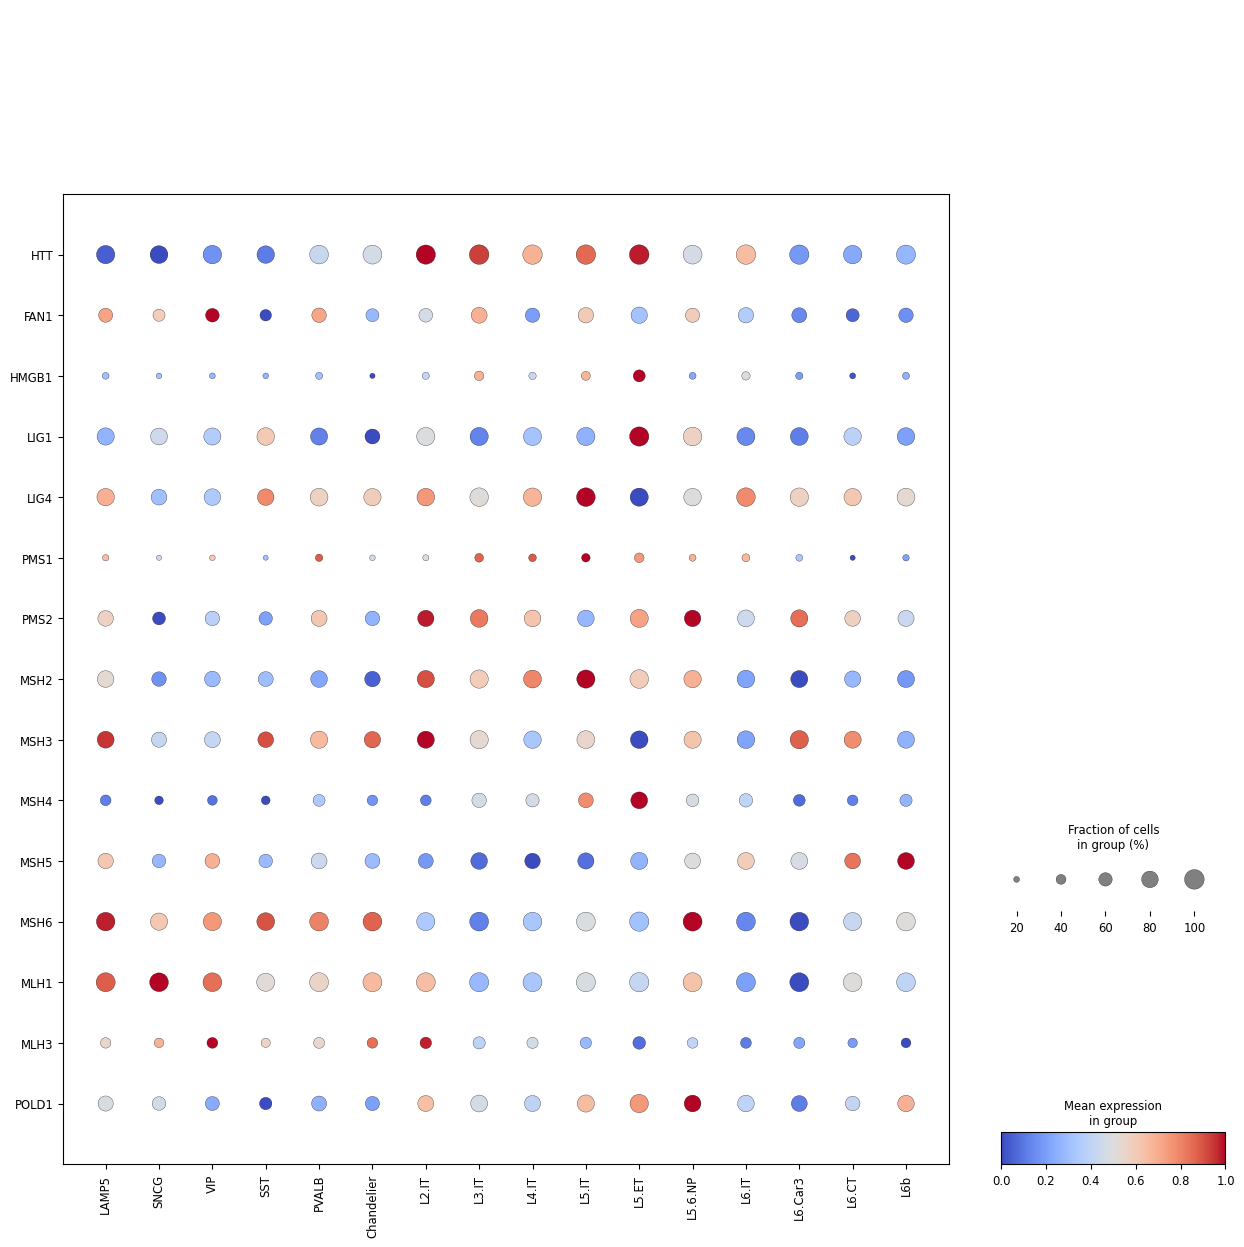

In [47]:
dna_repair = ['HTT','FAN1', 
'HMGB1', 'LIG1',  'LIG4', 'PMS1','PMS2','MSH2','MSH3','MSH4','MSH5', 
'MSH6', 'MLH1','MLH3','POLD1']

Neurons_CTL.obs['cluster_names'] = pd.Categorical(
    Neurons_CTL.obs['cluster_names'],
    categories=cluster_order_neu,
    ordered=True
)

fig, ax = plt.subplots(figsize=(15, 15), facecolor="white")

sc.pl.dotplot(
    Neurons_CTL,            
    var_names=dna_repair,  
    groupby='cluster_names', 
    standard_scale='var',    
    cmap='coolwarm',         
    ax=ax,                  
    swap_axes=True         
)

In [48]:
##################################################
####  FIGURES 4I: Expression of DNA repair genes
##################################################

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


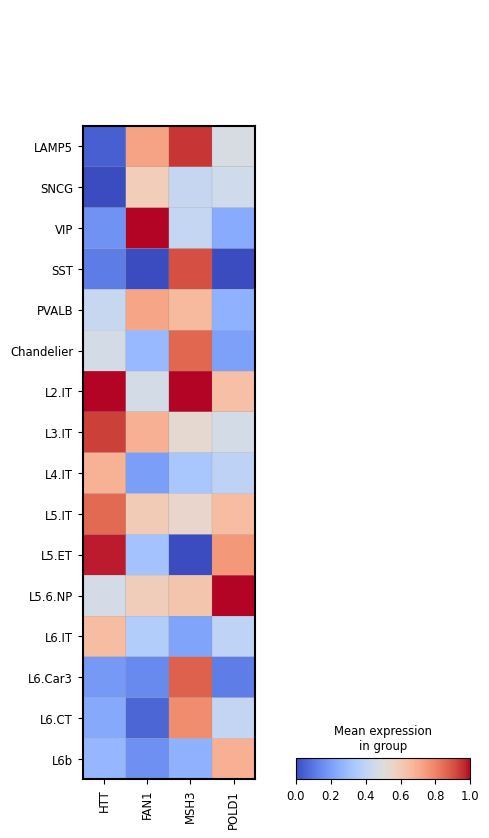

In [49]:
figure_dna_repair = ['HTT','FAN1', 'MSH3','POLD1']
fig, ax = plt.subplots(figsize=(5, 10), facecolor="white")
sc.pl.matrixplot(Neurons_CTL, figure_dna_repair, groupby='cluster_names', standard_scale='var', cmap='coolwarm', ax=ax)
ax.tick_params(axis="y", labelrotation=45)

In [50]:
##################################################
####  FIGURES 4J: DNA repair vs CAG
##################################################

In [51]:
X_neu = Neurons_CTL.X  

expr_raw_neu = pd.DataFrame(X.toarray() if hasattr(X_neu, 'toarray') else X_neu,
                        index=Neurons_CTL.obs_names,
                        columns=Neurons_CTL.var_names)

expr_raw_neu['cluster'] = Neurons_CTL.obs['cluster_names'].values
expr_df_neu = expr_raw_neu.groupby('cluster')[dna_repair].mean()

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/3224703057.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_df_neu = expr_raw_neu.groupby('cluster')[dna_repair].mean()


In [52]:
summary_df_hd = summary_df_hd.set_index('cluster_names')
exp_series = summary_df_hd['mean_with_exp']

In [53]:
cor_results = []

for g in dna_repair:
    common_clusters = exp_series.index.intersection(expr_df_neu.index)
    x = expr_df_neu.loc[common_clusters, g]        
    y = exp_series.loc[common_clusters]         
    
    r, p = spearmanr(x, y)
    cor_results.append({'Gene': g, 'Correlation': r, 'pvalue': p})

cor_df = pd.DataFrame(cor_results).sort_values('Correlation', ascending=True)

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


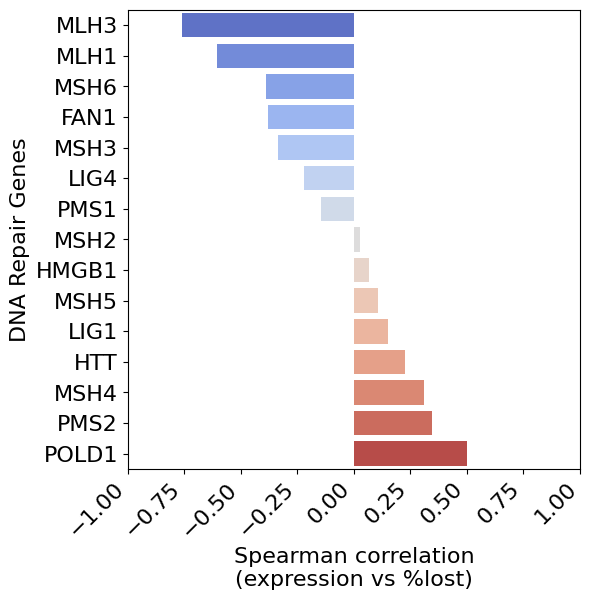

     Gene  Correlation    pvalue
13   MLH3    -0.761765  0.000605
12   MLH1    -0.602941  0.013424
11   MSH6    -0.388235  0.137282
1    FAN1    -0.379412  0.147227
8    MSH3    -0.335294  0.204255
4    LIG4    -0.220588  0.411666
5    PMS1    -0.147059  0.586793
7    MSH2     0.029412  0.913896
2   HMGB1     0.067647  0.803420
10   MSH5     0.108824  0.688288
3    LIG1     0.152941  0.571745
0     HTT     0.226471  0.398983
9    MSH4     0.308824  0.244499
6    PMS2     0.344118  0.191856
14  POLD1     0.500000  0.048580


In [54]:
plt.figure(figsize=(6,6))
sns.barplot(data=cor_df, y='Gene', x='Correlation', palette='coolwarm', hue=None)
plt.xticks(rotation=45, ha='right', size=16)
plt.yticks( size=16)
plt.xlabel(f'Spearman correlation\n(expression vs %lost)', fontsize=16)
plt.ylabel('DNA Repair Genes', fontsize=16)
plt.title('', fontsize=20)
plt.tight_layout()
plt.xlim(-1, 1)
plt.show()


print(cor_df)

In [55]:
##################################################
####  FIGURES 4K: DNA repair vs Neuronal loss
##################################################

In [56]:
percent_lost_df_neu = {
    'cluster_names': ['L2.IT', 'L3.IT', 'L5.IT', 'L4.IT', 'L5.ET', 'L5.6.NP', 'L6.IT', 'L6.CT', 'L6.Car3', 'L6b','Chandelier', 'LAMP5', 'PVALB', 'SNCG', 'SST', 'VIP' ],
    'Percent Lost': [38.965629, 7.597639, 21.390964, 44.542414, 9.159061, 84.112792, 24.816347, 42.304075, 2.011352, 53.409478,55.550050,7.380457, 14.008406,  -1.760563,   51.870968, 4.372169 ]
}

percent_lost_df_neu = pd.DataFrame(percent_lost_df_neu)
percent_lost_df_neu.set_index('cluster_names', inplace=True)

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


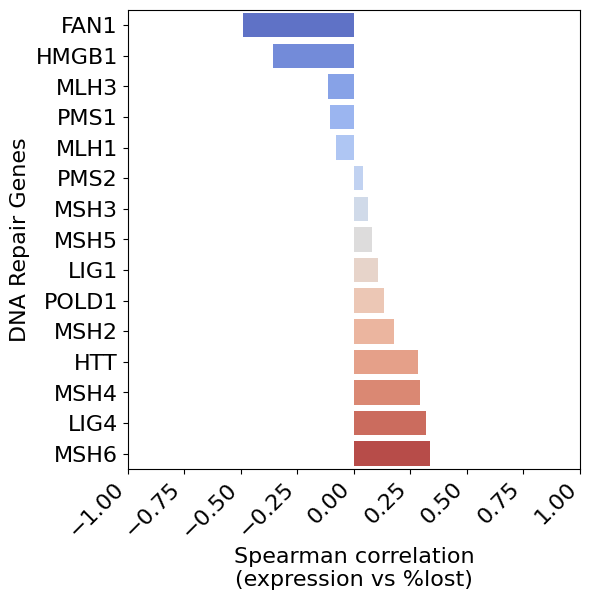

     Gene  Correlation    pvalue
1    FAN1    -0.491176  0.053350
2   HMGB1    -0.355882  0.176104
13   MLH3    -0.114706  0.672291
5    PMS1    -0.105882  0.696334
12   MLH1    -0.079412  0.770025
6    PMS2     0.041176  0.879654
8    MSH3     0.061765  0.820242
10   MSH5     0.079412  0.770025
3    LIG1     0.108824  0.688288
14  POLD1     0.132353  0.625106
7    MSH2     0.179412  0.506140
0     HTT     0.282353  0.289350
9    MSH4     0.291176  0.273887
4    LIG4     0.317647  0.230573
11   MSH6     0.335294  0.204255


In [57]:
cor_results = []
for g in dna_repair:
    common_clusters = percent_lost_df_neu.index.intersection(expr_df_neu.index)
    x = expr_df_neu.loc[common_clusters, g]
    y = percent_lost_df_neu.loc[common_clusters]
    
    r, p = spearmanr(x, y)
    cor_results.append({'Gene': g, 'Correlation': r, 'pvalue': p})

cor_df = pd.DataFrame(cor_results).sort_values('Correlation', ascending=True)

plt.figure(figsize=(6,6))
sns.barplot(data=cor_df, y='Gene', x='Correlation', palette='coolwarm', hue=None)
plt.xticks(rotation=45, ha='right', size=16)
plt.yticks( size=16)
plt.xlabel(f'Spearman correlation\n(expression vs %lost)', fontsize=16)
plt.ylabel('DNA Repair Genes', fontsize=16)
plt.title('', fontsize=20)
plt.tight_layout()
plt.xlim(-1, 1)
plt.show()

print(cor_df)

In [58]:
##################################################
#### SUPPLEMENTARY FIGURE 12C: FAN1 vs Population loss
##################################################

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


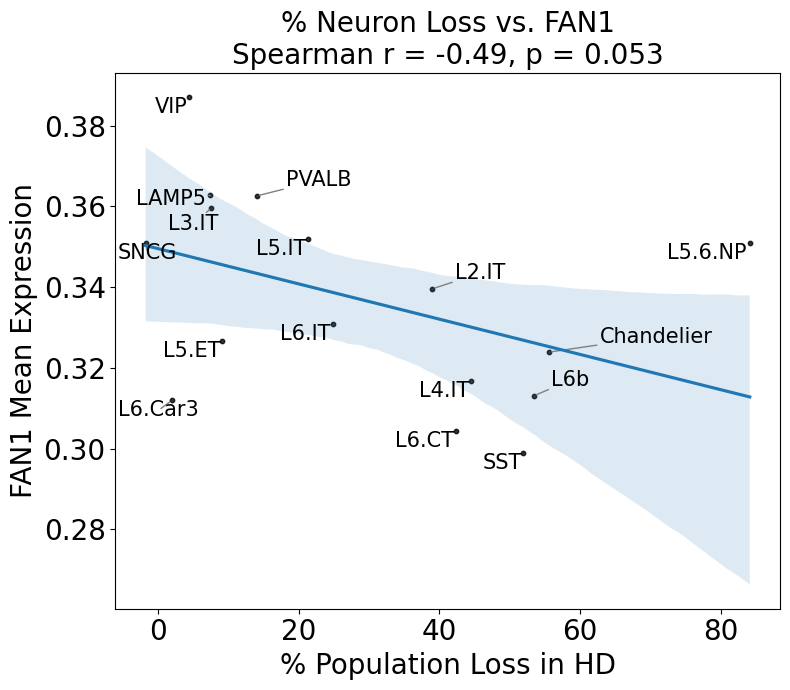

In [59]:
y = expr_df_neu.loc[common_clusters, 'FAN1']
x = percent_lost_df_neu.loc[common_clusters]

r, p = spearmanr(x, y)

plt.figure(figsize=(8, 7))
sns.regplot(x=x.values, y=y.values, scatter_kws={'s': 10, 'color': 'black'})

texts = []
for i, c in enumerate(common_clusters):
    texts.append(plt.text(x.iloc[i], y.iloc[i], c, fontsize=15))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'% Neuron Loss vs. FAN1\nSpearman r = {r:.2f}, p = {p:.3f}', fontsize=20)
plt.xlabel('% Population Loss in HD', fontsize=20)
plt.ylabel('FAN1 Mean Expression', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.show()

In [60]:
##################################################
#### SUPPLEMENTARY FIGURE 12B: DNA repair machinery expression in Allen Brain Atlas (ABA)
##################################################

In [61]:
counts = sc.read_h5ad('../../SEAAD_PFC/SEAAD_A9_RNAseq_final-nuclei.2024-02-13.h5ad')

In [62]:
counts.obs['Neurotypical reference'] = counts.obs['Neurotypical reference'].astype(str).map({'True': True, 'False': False})

In [63]:
CTL=counts[counts.obs['Neurotypical reference']==True].copy()
Neuron = CTL[CTL.obs['Class']!='Non-neuronal and Non-neural'].copy()

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(

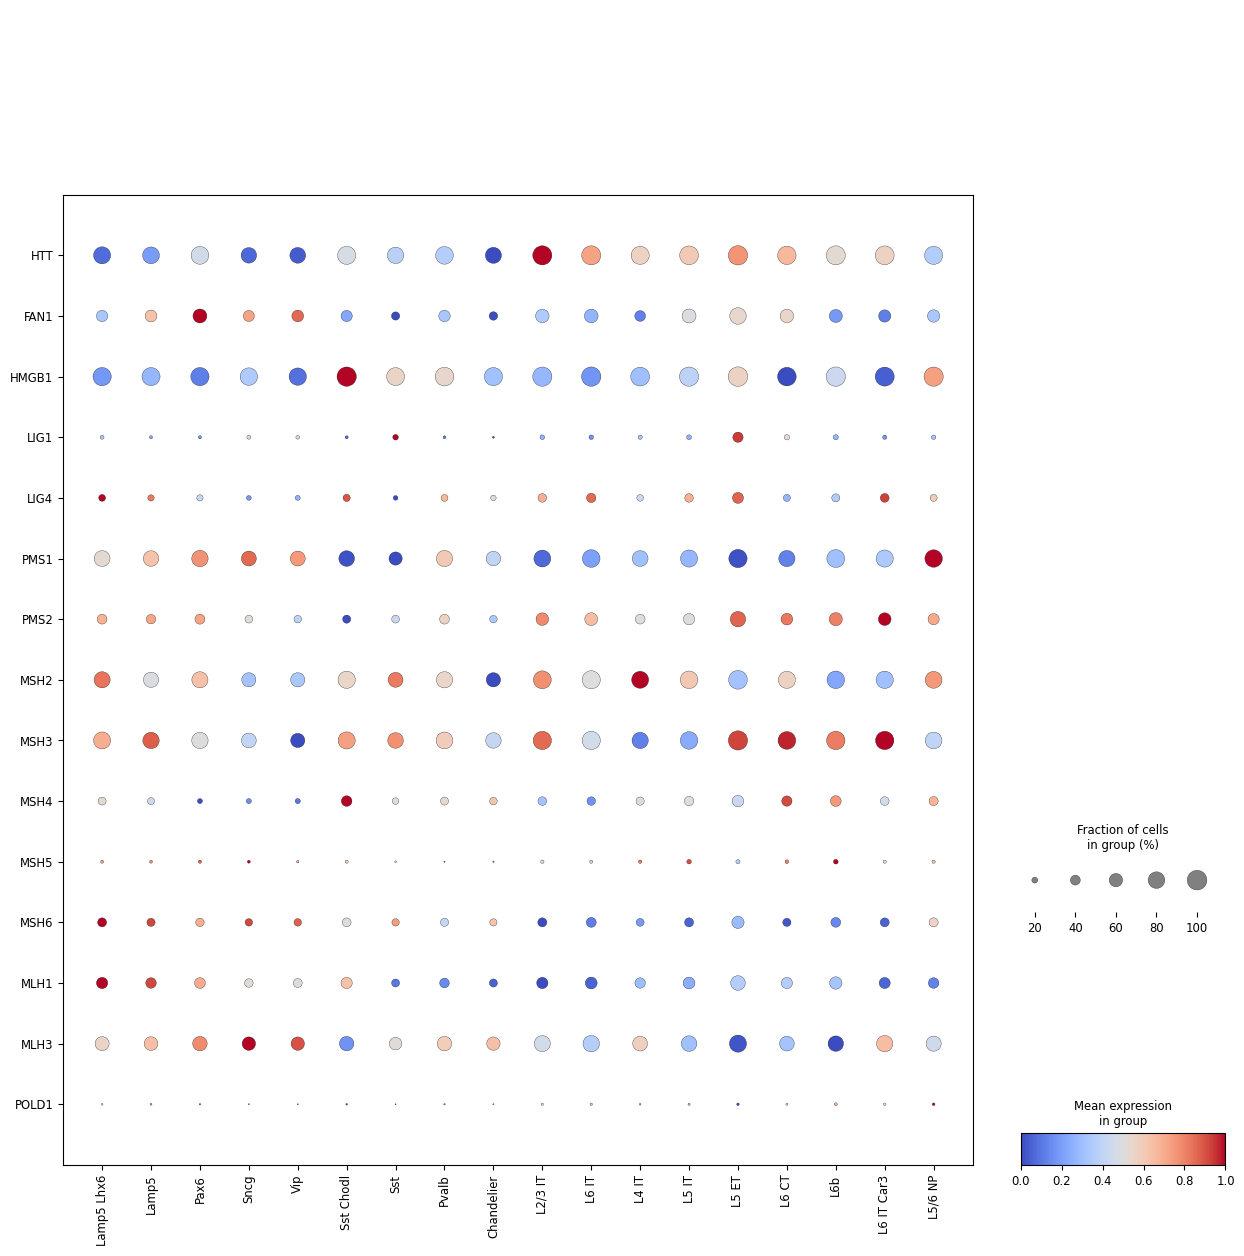

In [64]:
fig, ax = plt.subplots(figsize=(15, 15), facecolor="white")

sc.pl.dotplot(
    Neuron,             
    var_names=dna_repair,
    groupby='Subclass',   
    standard_scale='var',       
    cmap='coolwarm',             
    ax=ax,                      
    swap_axes=True             
)

In [65]:
##################################################
#### SUPPLEMENTARY FIGURE 12D: FAN1 vs Population loss in ABA
##################################################

In [66]:
percent_lost_df_neu_aba = {
    'cluster_names': ['L2/3 IT', 'L5 IT', 'L4 IT', 'L5 ET', 'L5/6 NP', 'L6 IT', 'L6 CT', 'L6 IT Car3', 'L6b','Chandelier', 'Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip' ],
    'Percent Lost': [23.28, 21.390964, 44.542414, 9.159061, 84.112792, 24.816347, 42.304075, 2.011352, 53.409478,55.550050,7.380457, 14.008406,  -1.760563,   51.870968, 4.372169 ]
}

percent_lost_df_neu_aba = pd.DataFrame(percent_lost_df_neu_aba)
percent_lost_df_neu_aba.set_index('cluster_names', inplace=True)

In [67]:
X_aba = Neuron.X 

expr_raw_aba = pd.DataFrame(X_aba.toarray() if hasattr(X_aba, 'toarray') else X_aba,
                        index=Neuron.obs_names,
                        columns=Neuron.var_names)

expr_raw_aba['cluster'] = Neuron.obs['Subclass'].values
expr_df_neu_aba = expr_raw_aba.groupby('cluster')[dna_repair].mean()

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50553/3103620011.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_df_neu_aba = expr_raw_aba.groupby('cluster')[dna_repair].mean()


/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


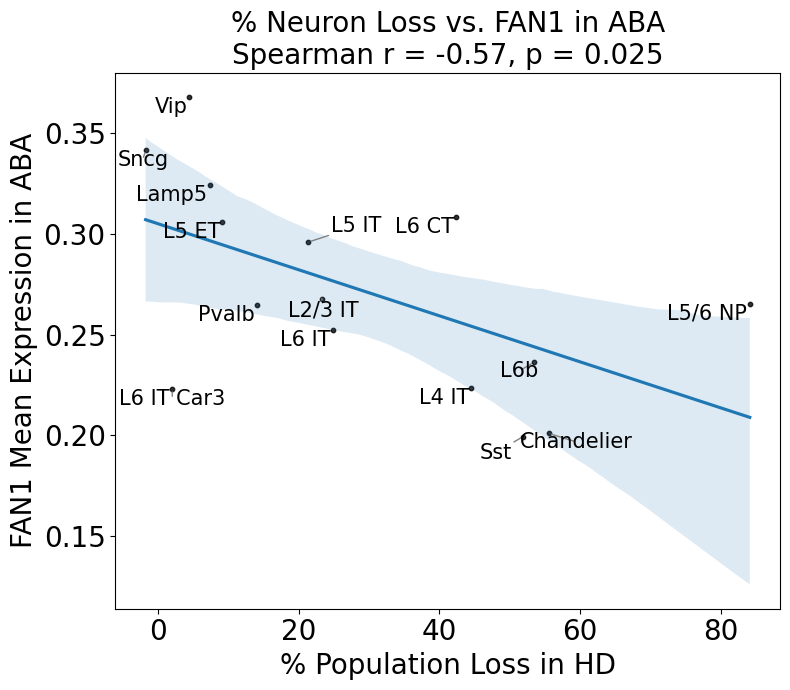

In [68]:
common_clusters_aba = percent_lost_df_neu_aba.index.intersection(expr_df_neu_aba.index)
y = expr_df_neu_aba.loc[common_clusters_aba, 'FAN1']
x = percent_lost_df_neu_aba.loc[common_clusters_aba]

r, p = spearmanr(x, y)

plt.figure(figsize=(8, 7))
sns.regplot(x=x.values, y=y.values, scatter_kws={'s': 10, 'color': 'black'})

texts = []
for i, c in enumerate(common_clusters_aba):
    texts.append(plt.text(x.iloc[i], y.iloc[i], c, fontsize=15))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'% Neuron Loss vs. FAN1 in ABA\nSpearman r = {r:.2f}, p = {p:.3f}', fontsize=20)
plt.xlabel('% Population Loss in HD', fontsize=20)
plt.ylabel('FAN1 Mean Expression in ABA', fontsize=20)
plt.xticks(fontsize=20)
#plt.ylim(0.4, 2.4)
plt.yticks(fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.show()

In [69]:
##################################################
#### SUPPLEMENTARY FIGURE 12E: POLD1 vs CAG
##################################################

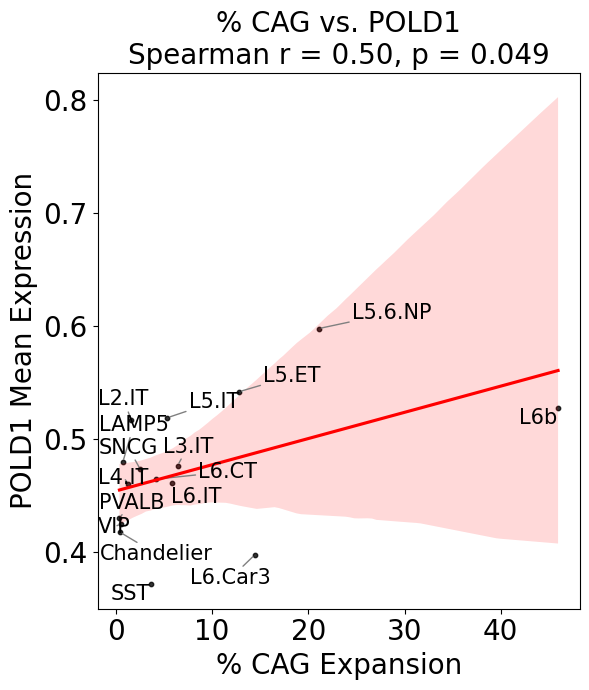

In [70]:
y = expr_df_neu.loc[common_clusters, 'POLD1']
x = exp_series.loc[common_clusters]

r, p = spearmanr(x, y)

plt.figure(figsize=(6, 7))
sns.regplot(x=x.values, y=y.values, scatter_kws={'s': 10, 'color': 'black'},line_kws={'color': 'red'})

texts = []
for i, c in enumerate(common_clusters):
    texts.append(plt.text(x.iloc[i], y.iloc[i], c, fontsize=15))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'% CAG vs. POLD1\nSpearman r = {r:.2f}, p = {p:.3f}', fontsize=20)
plt.xlabel('% CAG Expansion', fontsize=20)
plt.ylabel('POLD1 Mean Expression', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.show()

In [71]:
##################################################
#### SUPPLEMENTARY FIGURE 12F: MLH3 vs CAG
##################################################

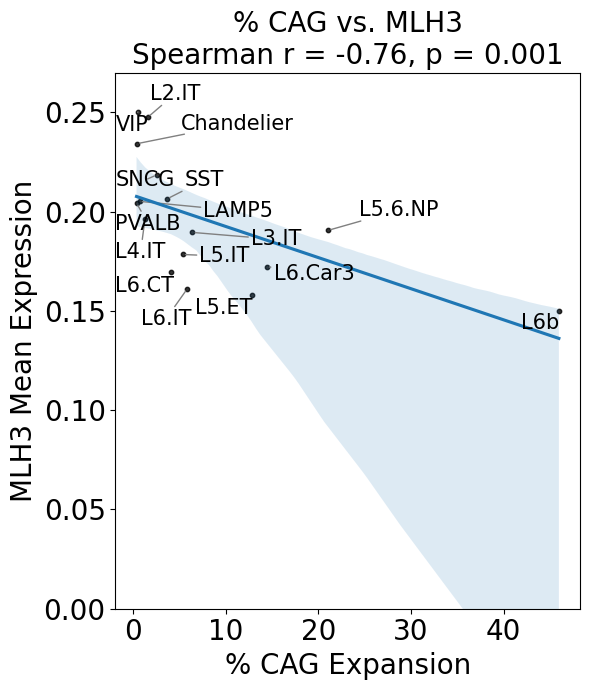

In [72]:
y = expr_df_neu.loc[common_clusters, 'MLH3']
x = exp_series.loc[common_clusters]

r, p = spearmanr(x, y)

plt.figure(figsize=(6, 7))
sns.regplot(x=x.values, y=y.values, scatter_kws={'s': 10, 'color': 'black'})

texts = []
for i, c in enumerate(common_clusters):
    texts.append(plt.text(x.iloc[i], y.iloc[i], c, fontsize=15))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'% CAG vs. MLH3\nSpearman r = {r:.2f}, p = {p:.3f}', fontsize=20)
plt.xlabel('% CAG Expansion', fontsize=20)
plt.ylabel('MLH3 Mean Expression', fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(0, 0.27)
plt.yticks(fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.show()

In [73]:
##################################################
#### SUPPLEMENTARY FIGURE 12G: MLH1 vs CAG
##################################################

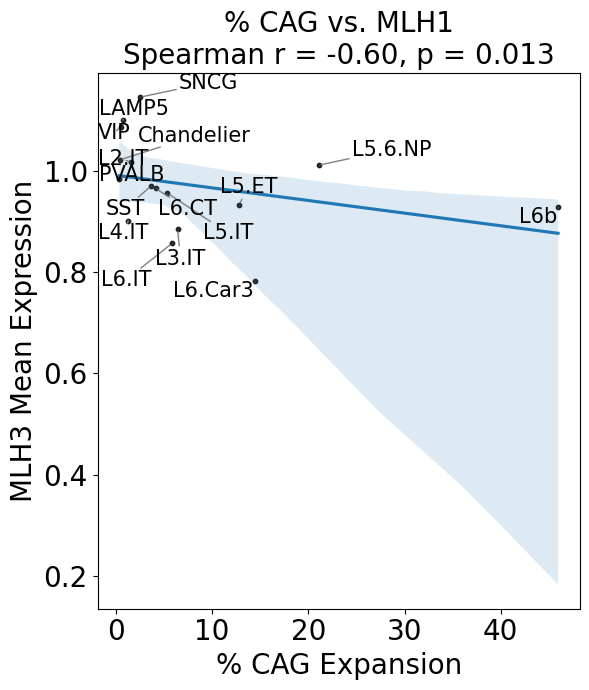

In [74]:
y = expr_df_neu.loc[common_clusters, 'MLH1']
x = exp_series.loc[common_clusters]

r, p = spearmanr(x, y)

plt.figure(figsize=(6, 7))
sns.regplot(x=x.values, y=y.values, scatter_kws={'s': 10, 'color': 'black'})

texts = []
for i, c in enumerate(common_clusters):
    texts.append(plt.text(x.iloc[i], y.iloc[i], c, fontsize=15))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title(f'% CAG vs. MLH1\nSpearman r = {r:.2f}, p = {p:.3f}', fontsize=20)
plt.xlabel('% CAG Expansion', fontsize=20)
plt.ylabel('MLH3 Mean Expression', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.show()